In [21]:
import numpy as np
import ten
import ipywidgets as widgets
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ["svg"]

$$
W = \begin{pmatrix}
\sqrt{\cosh(1/t)} & \sqrt{\sinh(1/t)} \\
\sqrt{\cosh(1/t)} & -\sqrt{\sinh(1/t)}
\end{pmatrix}
$$

In [22]:
def W(temp: float, dtype=np.float32) -> np.ndarray:
	return np.array([
		[np.sqrt(np.cosh(1/temp)), np.sqrt(np.sinh(1/temp))],
		[np.sqrt(np.cosh(1/temp)), -np.sqrt(np.sinh(1/temp))],
	], dtype=dtype)

$$
T_{lrud} = \sum_\alpha W_{\alpha,l} W_{\alpha,r} W_{\alpha,u} W_{\alpha,d}
$$

In [23]:
def T(temp: float, dtype=np.float32) -> np.ndarray:
	w = W(temp, dtype)
	return np.einsum("al,ar,au,ad->lrud", w, w, w, w)

In [4]:
temperature = widgets.FloatSlider(min=2, max=5)
temperature

FloatSlider(value=2.0, max=5.0, min=2.0)

In [5]:
D = widgets.IntSlider(min=2, max=16)
D

IntSlider(value=2, max=16, min=2)

In [6]:
t = T(temperature.value)
t

array([[[[2.5430813 , 0.        ],
         [0.        , 1.1752013 ]],

        [[0.        , 1.1752013 ],
         [1.1752013 , 0.        ]]],


       [[[0.        , 1.1752013 ],
         [1.1752013 , 0.        ]],

        [[1.1752013 , 0.        ],
         [0.        , 0.54308057]]]], dtype=float32)

In [7]:
def M(tensor: np.ndarray) -> np.ndarray:
	m = np.einsum("abci,deif->adbecf", tensor, tensor)
	return m.reshape((m.shape[0]*m.shape[1], m.shape[2]*m.shape[3], m.shape[4], m.shape[5]))

In [8]:
m = M(t)
S, Us = ten.hosvd(m)

$$
\varepsilon_1 = \sum_{i > D} \vert S_{i,:,:,:} \vert^2
$$

In [9]:
eps1 = sum(np.sum(np.square(np.abs(S[i,:]))) for i in range(D.value, S.shape[0]))
eps1

10.105166673660278

$$
\varepsilon_2 = \sum_{j > D} \vert S_{:,j,:,:} \vert^2
$$

In [10]:
eps2 = sum(np.sum(np.square(np.abs(S[:,j,:]))) for j in range(D.value, S.shape[1]))
eps2

10.105167388916016

$$
U^{(n+1)} = \begin{cases}
U^L & \varepsilon_1 < \varepsilon_2 \\
U^R & \text{otherwise}
\end{cases}
$$

In [12]:
# TODO renormalize?
U = Us[0 if eps1 < eps2 else 1]

# truncate to D
U = U[:, 0:D.value]
U.shape

(4, 2)

$$
T^{(n+1)}_{lrud} = \sum_{ij} U^{(n+1)}_{il} ~ M^{(n)}_{ijud} ~ U^{(n+1)}_{jr}
$$

In [13]:
m.shape

(4, 4, 2, 2)

In [14]:
U.shape

(4, 2)

In [15]:
t = np.einsum("il,ijud,jr->lrud", U, m, U)
t.shape

(2, 2, 2, 2)

$$
Z = \text{Tr} \prod_i T_{l_i r_i u_i d_i}
$$

In [16]:
Z = np.einsum("iijj->", t)
Z

15.265842

## Iterative version

In [18]:
steps = widgets.IntSlider(min=4, max=10)
steps

IntSlider(value=4, max=10, min=4)

In [42]:
temperature = widgets.FloatSlider(min=2, max=5)
temperature

FloatSlider(value=2.0, max=5.0, min=2.0)

In [43]:
D = widgets.IntSlider(min=2, max=16)
D

IntSlider(value=2, max=16, min=2)

In [24]:
def Z(tensor: np.ndarray) -> float:
	return np.einsum("iijj->", tensor)

11.501381
93.482124
5779.866
21071864.0
275602250000000.0
inf


LinAlgError: SVD did not converge

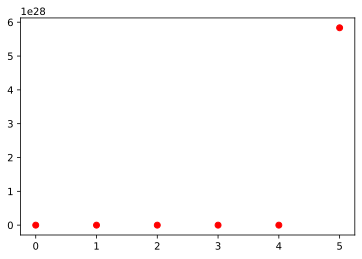

In [56]:
fig = plt.figure()
ax = fig.subplots(1)

t = T(temperature.value)

for n in range(steps.value):
	m = M(t)
	S, Us = ten.hosvd(m)

	print(np.linalg.norm(S))

	# TODO renormalize?
	U = Us[0 if eps1 < eps2 else 1]

	# truncate U
	if U.shape[1] > D.value:
		U = U[:, 0:D.value]
		# U /= np.linalg.norm(U)

	# new T
	t = np.einsum("il,ijud,jr->lrud", U, m, U)
	
	z = Z(t)
	ax.plot(n, z, "ro")